In [1]:
import pandana as pdna
# from pandana.loaders import osm
import pandas as pd
from ipywidgets import FloatSlider, interact
from IPython.core.display import display
from urbansim.utils import misc
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap

#Set number of unique Pandana networks that will be generated in this session
#pdna.network.reserve_num_graphs(5)

%matplotlib inline

In [2]:
#set directory
raw = '/Users/briangoggin/Dropbox/CP 201A/Fruitvale/Raw Data/'

In [3]:
#define function to plot nodes in case I want to
def plot_nodes(x_data=None,y_data=None,node_size=15,node_color='black',color_map=None,edge_color=None):
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, s=node_size, c=node_color,
                   alpha=1, edgecolor=edge_color,cmap=color_map,
                   zorder=3)
    plt.show()
    return fig, ax

# Import block-level jobs data

In [4]:
blocks = pd.read_csv(raw+'/LODES Workplace Locations Alameda County/AC_jobs_by_block.txt', sep=",")

In [5]:
blocks.set_index('id', inplace = True)

In [6]:
blocks.head()

,FID,c000,ca01,ca02,ca03,ce01,ce02,ce03,cns01,cns02,...,ct01,ct02,cd01,cd02,cd03,cd04,cg01,cg02,Latitude,Longitude
id,,,,,,,,,,,,,,,,,,,,,
60014001001007,0,45.0,17.0,15.0,13.0,16.0,7.0,22.0,0.0,0.0,...,38.0,7.0,3.0,6.0,7.0,12.0,8.0,37.0,37.868576,-122.235456
60014001001008,1,26.0,3.0,15.0,8.0,3.0,5.0,18.0,0.0,0.0,...,24.0,2.0,2.0,2.0,10.0,9.0,13.0,13.0,37.862399,-122.243030
60014001001017,2,9.0,2.0,3.0,4.0,1.0,1.0,7.0,0.0,0.0,...,9.0,0.0,0.0,2.0,1.0,4.0,7.0,2.0,37.868959,-122.241452
60014001001024,3,22.0,9.0,10.0,3.0,9.0,6.0,7.0,0.0,0.0,...,20.0,2.0,2.0,7.0,3.0,1.0,10.0,12.0,37.861152,-122.237697
60014001001026,4,4.0,1.0,2.0,1.0,0.0,3.0,1.0,0.0,0.0,...,2.0,2.0,2.0,0.0,1.0,0.0,1.0,3.0,37.860244,-122.235771


# Import and Set Network

In [8]:
%%time
hdffile = '/Bus+Pedestrian Network/transit_ped_network.h5'
transit_nodes = pd.HDFStore(raw+hdffile).nodes
transit_edges = pd.HDFStore(raw+hdffile).edges
transit_edges.drop('id', axis=1, inplace=True)

CPU times: user 54.1 ms, sys: 35.6 ms, total: 89.7 ms
Wall time: 93.4 ms


The transit network represents the AM Peak scheduled network of AC Transit from 7 am to 10 am with edges weighted by travel time. Pedestrian to transit connector edges have been weighted by the average route stop headways to represent expected passenger wait time. This network has been integrated with the pedestrian network which uses a standard walking speed of 3 MPH to calculate the pedestrian travel time.

In [65]:
%%time
transit_net = pdna.Network(transit_nodes["x"], 
                           transit_nodes["y"], 
                           transit_edges["from"], 
                           transit_edges["to"],
                           transit_edges[["weight"]],twoway=False)

CPU times: user 24.6 s, sys: 123 ms, total: 24.7 s
Wall time: 24.7 s


In [66]:
%%time
%%capture
blocks['node_id'] = transit_net.get_node_ids(blocks['Longitude'], blocks['Latitude'])
blocks.rename(columns={'c000' : 'total_jobs', 'cns12': 'pro', 'cns13': 'management','cns14': 'waste', 'cns15': 'ed', 'cns16': 'health', 'cns17': 'art', 'cns18': 'acc', 'cns04': 'cons', 'cns07': 'retail', 'cns05': 'manu', 'ce01': 'low', 'ce02': 'middle', 'ce03': 'high'}, inplace = True)

CPU times: user 22.9 ms, sys: 1.84 ms, total: 24.7 ms
Wall time: 23.4 ms


In [67]:
# create aggregate categories
blocks['pro_jobs'] = blocks['pro'] + blocks['management'] + blocks['waste']
blocks['ed_jobs'] = blocks['ed'] + blocks['health']
blocks['art_jobs'] = blocks['art'] + blocks['acc']


In [69]:
%%time
# Set jobs onto the network
transit_net.set(blocks.node_id, variable = blocks.total_jobs, name='total_jobs')
transit_net.set(blocks.node_id, variable = blocks.pro_jobs, name='pro_jobs')
transit_net.set(blocks.node_id, variable = blocks.ed_jobs, name='ed_jobs')
transit_net.set(blocks.node_id, variable = blocks.art_jobs, name='art_jobs')
transit_net.set(blocks.node_id, variable = blocks.cons, name='cons_jobs')
transit_net.set(blocks.node_id, variable = blocks.retail, name='retail_jobs')
transit_net.set(blocks.node_id, variable = blocks.manu, name='manu_jobs')
transit_net.set(blocks.node_id, variable = blocks.low, name='low_jobs')
transit_net.set(blocks.node_id, variable = blocks.middle, name='middle_jobs')
transit_net.set(blocks.node_id, variable = blocks.high, name='high_jobs')


CPU times: user 198 ms, sys: 44.2 ms, total: 243 ms
Wall time: 242 ms


# Aggregation Queries

Run an aggregation query to calculate the total number of jobs accessible within a 45 minute travel time along the transit+pedestrian network.

In [70]:
%%time
#aggregate for 45 minutes
total_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'total_jobs')
pro_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'pro_jobs')
ed_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'ed_jobs')
art_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'art_jobs')
cons_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'cons_jobs')
retail_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'retail_jobs')
manu_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'manu_jobs')
low_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'low_jobs')
middle_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'middle_jobs')
high_jobs_45 = transit_net.aggregate(45, type='sum', decay='linear', name = 'high_jobs')



CPU times: user 1h 38min 7s, sys: 20.9 s, total: 1h 38min 28s
Wall time: 1h 38min 36s


In [114]:
%%time
total_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'total_jobs')

CPU times: user 4min 44s, sys: 826 ms, total: 4min 45s
Wall time: 4min 45s


In [115]:
%%time
#aggregate for 26 minutes
pro_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'pro_jobs')
ed_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'ed_jobs')
art_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'art_jobs')
cons_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'cons_jobs')
retail_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'retail_jobs')
manu_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'manu_jobs')
low_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'low_jobs')
middle_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'middle_jobs')
high_jobs_26 = transit_net.aggregate(26, type='sum', decay='linear', name = 'high_jobs')


CPU times: user 42min 24s, sys: 7.47 s, total: 42min 31s
Wall time: 42min 34s


# 26 Minute Accessibility Export

In [117]:
results_transit26 = pd.DataFrame({'total_jobs_26':misc.reindex(total_jobs_26, blocks.node_id),
                               'pro_jobs_26':misc.reindex(pro_jobs_26, blocks.node_id),
                               'ed_jobs_26':misc.reindex(ed_jobs_26, blocks.node_id), 
                               'art_jobs_26':misc.reindex(art_jobs_26, blocks.node_id), 
                               'cons_jobs_26':misc.reindex(cons_jobs_26, blocks.node_id), 
                               'retail_jobs_26':misc.reindex(retail_jobs_26, blocks.node_id), 
                               'manu_jobs_26':misc.reindex(manu_jobs_26, blocks.node_id), 
                               'low_jobs_26':misc.reindex(low_jobs_26, blocks.node_id), 
                               'middle_jobs_26':misc.reindex(middle_jobs_26, blocks.node_id), 
                               'high_jobs_26':misc.reindex(high_jobs_26, blocks.node_id)})

results_transit26['block_id'] = results_transit26.index
results_transit26.tail()

,art_jobs_26,cons_jobs_26,ed_jobs_26,high_jobs_26,low_jobs_26,manu_jobs_26,middle_jobs_26,pro_jobs_26,retail_jobs_26,total_jobs_26,block_id
id,,,,,,,,,,,
60019832001051,22355.414062,7980.379395,52419.761719,99810.937500,44330.941406,9264.975586,52467.996094,34740.964844,17084.011719,196609.875000,60019832001051
60019832001052,23098.851562,8340.788086,54070.222656,103285.265625,45798.761719,9835.436523,54633.312500,35944.707031,17878.914062,203717.343750,60019832001052
60019832001053,21743.982422,7730.909668,50752.050781,96977.031250,43001.585938,8923.478516,50877.550781,33791.980469,16549.912109,190856.171875,60019832001053
60019832001054,23065.513672,8390.039062,54238.972656,103660.851562,45944.554688,9831.539062,54852.433594,36105.785156,17874.421875,204457.843750,60019832001054
60019832001055,22502.378906,8039.107910,52470.734375,100354.921875,44484.988281,9357.273438,52836.800781,34972.710938,17222.738281,197676.703125,60019832001055


In [118]:
coordinates = blocks[['Latitude', 'Longitude']]
coordinates['block_id'] = coordinates.index

/Users/briangoggin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [119]:
# merge coordinates with final results
final26 = results_transit26.merge(coordinates, how = 'outer', on = 'block_id', indicator = True)

In [120]:
#round estimates and convert them to integers
list = ['art_jobs_26', 'cons_jobs_26', 'ed_jobs_26', 'high_jobs_26', 'low_jobs_26', 'manu_jobs_26', 'middle_jobs_26', 
       'pro_jobs_26', 'retail_jobs_26', 'total_jobs_26']

for item in list:
    final26[item] = final26[item].round(0)
    final26[item] = final26[item].astype(int)
    

In [121]:
#finally, export file
export_path = '/Users/briangoggin/Dropbox/CP 201A/Fruitvale/Output/'
final26.to_csv(export_path+'AC_26minute_accessibility.csv')


# 45 minute accessibility export

In [101]:
results_transit45 = pd.DataFrame({'total_jobs_45':misc.reindex(total_jobs_45, blocks.node_id),
                               'pro_jobs_45':misc.reindex(pro_jobs_45, blocks.node_id),
                               'ed_jobs_45':misc.reindex(ed_jobs_45, blocks.node_id), 
                               'art_jobs_45':misc.reindex(art_jobs_45, blocks.node_id), 
                               'cons_jobs_45':misc.reindex(cons_jobs_45, blocks.node_id), 
                               'retail_jobs_45':misc.reindex(retail_jobs_45, blocks.node_id), 
                               'manu_jobs_45':misc.reindex(manu_jobs_45, blocks.node_id), 
                               'low_jobs_45':misc.reindex(low_jobs_45, blocks.node_id), 
                               'middle_jobs_45':misc.reindex(middle_jobs_45, blocks.node_id), 
                               'high_jobs_45':misc.reindex(high_jobs_45, blocks.node_id)})

results_transit45['block_id'] = results_transit45.index
results_transit45.tail()

,art_jobs_45,cons_jobs_45,ed_jobs_45,high_jobs_45,low_jobs_45,manu_jobs_45,middle_jobs_45,pro_jobs_45,retail_jobs_45,total_jobs_45,block_id
id,,,,,,,,,,,
60019832001051,30853.482422,12807.011719,75315.710938,142787.546875,63894.039062,17734.486328,80333.437500,48569.027344,26770.490234,287015.03125,60019832001051
60019832001052,31406.738281,13096.334961,76612.882812,145474.937500,65059.132812,18240.937500,82086.570312,49519.625000,27379.339844,292620.62500,60019832001052
60019832001053,30429.818359,12618.841797,74155.031250,140771.390625,62944.886719,17444.111328,79133.250000,47879.660156,26375.119141,282849.53125,60019832001053
60019832001054,31421.853516,13147.424805,76804.226562,145878.484375,65230.617188,18287.867188,82351.054688,49682.820312,27417.253906,293460.15625,60019832001054
60019832001055,30957.898438,12853.071289,75398.859375,143206.859375,64032.605469,17814.425781,80624.679688,48742.375000,26874.023438,287864.12500,60019832001055


In [102]:
coordinates = blocks[['Latitude', 'Longitude']]
coordinates['block_id'] = coordinates.index

/Users/briangoggin/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [103]:
# merge coordinates with final results
final45 = results_transit45.merge(coordinates, how = 'outer', on = 'block_id', indicator = True)

In [104]:
#round estimates and convert them to integers
list = ['art_jobs_45', 'cons_jobs_45', 'ed_jobs_45', 'high_jobs_45', 'low_jobs_45', 'manu_jobs_45', 'middle_jobs_45', 
       'pro_jobs_45', 'retail_jobs_45', 'total_jobs_45']

for item in list:
    final45[item] = final45[item].round(0)
    final45[item] = final45[item].astype(int)
    

In [105]:
final45.head()

,art_jobs_45,cons_jobs_45,ed_jobs_45,high_jobs_45,low_jobs_45,manu_jobs_45,middle_jobs_45,pro_jobs_45,retail_jobs_45,total_jobs_45,block_id,Latitude,Longitude,_merge
0,16,0,0,22,17,0,7,23,0,46,60014001001007,37.868576,-122.235456,both
1,0,0,0,18,3,0,5,0,0,26,60014001001008,37.862399,-122.243030,both
2,15,0,0,27,16,0,7,30,0,51,60014001001017,37.868959,-122.241452,both
3,11,0,2,7,9,3,6,0,0,22,60014001001024,37.861152,-122.237697,both
4,12,6,19,30,24,4,24,17,4,78,60014001001026,37.860244,-122.235771,both


In [112]:
#finally, export file
export_path = '/Users/briangoggin/Dropbox/CP 201A/Fruitvale/Output/'
final45.to_csv(export_path+'AC_45minute_accessibility.csv')


# Make map in notebook to view

(<mpl_toolkits.basemap.Basemap at 0x11ba1a5d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118bb3790>)

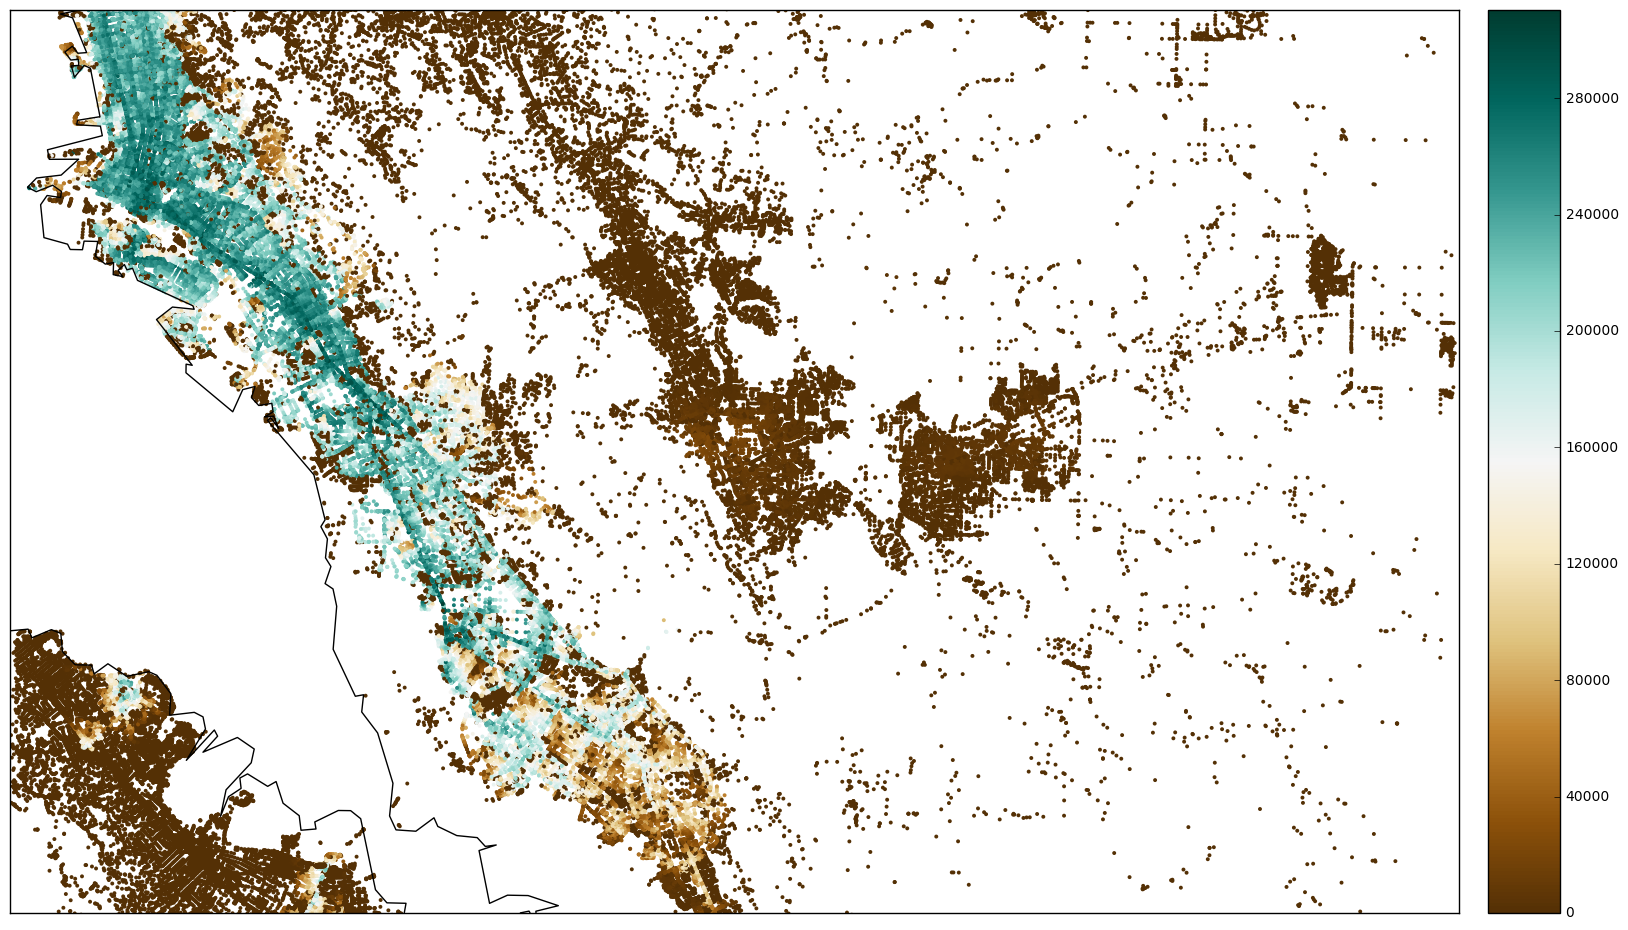

In [113]:
bbox = (37.454539,-122.342665,37.905668,-121.469214) # alameda county
transit_net.plot(total_jobs_45, 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'3310','resolution':'h'},
         plot_kwargs={'cmap':'BrBG','s':8,'edgecolor':'none'})

(<mpl_toolkits.basemap.Basemap at 0x11d01e6d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12382ed90>)

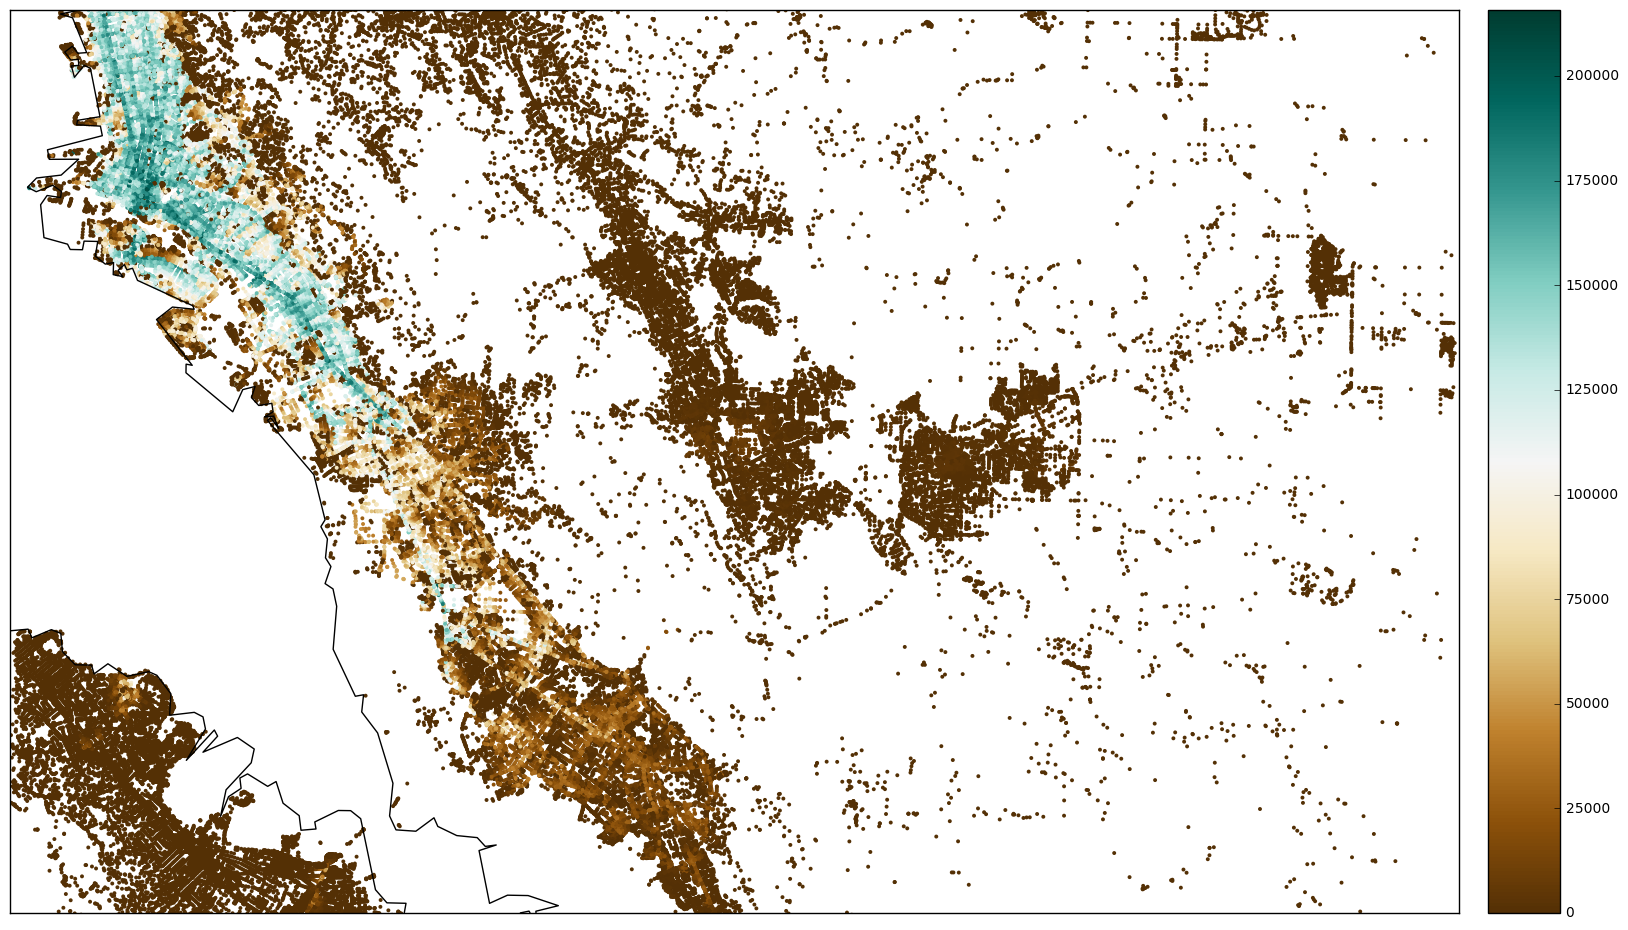

In [116]:
bbox = (37.454539,-122.342665,37.905668,-121.469214) # alameda county
transit_net.plot(total_jobs_26, 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'3310','resolution':'h'},
         plot_kwargs={'cmap':'BrBG','s':8,'edgecolor':'none'})